# Test the hologram performances with HD205905 data 5 jun 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   : October 2nd th 2017
- update : October 6th 2017


The goal of this notebook is to find the parameters that optimize the1-D spectrum for the 2-D image of the disperse
spectrum.
In particular the width around the dispersion axis is very important. This width may bias the computation of equavalent width.
Moreover, we check in this notebook that the wavelength calibration make sense, ie, the position of the order 0 central star in the original image is correct, allowing wavelength calibration





#### problem because limitation in output of data

- firt I tried to generate a config file for jupyter

If you ran jupyter notebook --generate-config to create it, it should be in the correct place already. If not, try putting it at ~/.jupyter/jupyter_notebook_config.py

- and I set : 
> c.NotebookApp.iopub_data_rate_limit = 1000000

but it failed again so I launch jupyter as follow:

> jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000 Ana2DShapeSpectra.ipynb

So it behaves better

In [2]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

print theNotebook
from IPython.display import Image, display
import sys
sys.path.append("../../common_tools/")
from common_notebook import *

init_notebook()

Ana2DShapeSpectra
ccdproc version 1.2.0
bottleneck version 1.2.1
/Users/dagoret/MacOSX/GitHub/LSST/CTIOAnaJun2017/CTIOAnaJun2017/ana_05jun17/HD205905


In [4]:
from astropy.modeling import models, fitting

In [5]:
import pandas as pd

# Input directory

In [6]:
inputdir="./rotated_fitsimages"
MIN_IMGNUMBER=46
MAX_IMGNUMBER=126
date="20170605"
object_name='HD205905'
tag = "rotimg"
SelectTagRe='^%s_%s_([0-9]+).fits$' % (tag,date) # regular expression to select the file
SearchTagRe='^%s_%s_[0-9]+.fits$' % (tag,date)
NBIMGPERROW=2

# Output directory

In [7]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images
ensure_dir(dir_top_images) # create that directory

outputdir="./spectrum_fitsspec"
ensure_dir(outputdir)

# Open files
===================================

## order 0 position in original image

In [8]:
df=pd.read_csv('xy_pointing.csv')
x_star=df["x_pointing"]
y_star=df["y_pointing"]
all_theta=df["theta"]
x_pointing=x_star
y_pointing=y_star

In [9]:
order0_positions = np.array([x_pointing,y_pointing]).T

In [10]:
df.head()

Unnamed: 0     theta  x_pointing  y_pointing
0           0 -0.472230  734.200949  647.719075
1           1 -0.966581  733.994455  645.712814
2           2 -1.897160  824.112296  585.786300
3           3 -1.417726  823.588894  585.639502
4           4 -0.479984  731.701102  645.702776

## order 0 position in rotated and cut image

In [11]:
df2=pd.read_csv('x_y_guess2.csv')
x_star2=df2["x_guess2"]
y_star2=df2["y_guess2"]
order0_positions2 = np.array([x_star2,y_star2]).T

In [12]:
df2.head()

Unnamed: 0     theta    x_guess2    y_guess2
0           0 -0.472230  735.253647  106.836525
1           1 -0.966581  735.587069  113.552699
2           2 -1.897160  826.780529  128.344163
3           3 -1.417726  825.593652  121.198030
4           4 -0.479984  732.701053  106.762561

## Input image files

- rotated and cut images

In [13]:
sorted_numbers,sorted_files = MakeFileList([inputdir],MIN_IMGNUMBER,MAX_IMGNUMBER,SelectTagRe,SearchTagRe) 
all_dates,all_airmass,all_images,all_titles,all_header,all_expo,all_filt,all_filt1,all_filt2=BuildImages(sorted_files,sorted_numbers,object_name)

print 'Number of images:',len(all_images)
print all_images[0].shape

Number of images: 80
(100, 2048)


In [14]:
print all_filt

['dia Thor300', 'dia HoloPhP', 'dia HoloPhAg', 'dia HoloAmAg', 'dia Thor300', 'dia HoloPhP', 'dia HoloPhAg', 'dia HoloAmAg', 'dia Thor300', 'dia HoloPhP', 'dia HoloPhAg', 'dia HoloAmAg', 'dia Thor300', 'dia HoloPhP', 'dia HoloPhAg', 'dia HoloAmAg', 'dia Thor300', 'dia HoloPhP', 'dia HoloPhAg', 'dia HoloAmAg', 'dia Thor300', 'dia HoloPhP', 'dia HoloPhAg', 'dia HoloAmAg', 'dia Thor300', 'dia HoloPhP', 'dia HoloPhAg', 'dia HoloAmAg', 'dia Thor300', 'dia HoloPhP', 'dia HoloPhAg', 'dia HoloAmAg', 'dia Thor300', 'dia HoloPhP', 'dia HoloPhAg', 'dia HoloAmAg', 'dia Thor300', 'dia HoloPhP', 'dia HoloPhAg', 'dia HoloAmAg', 'dia Thor300', 'dia HoloPhP', 'dia HoloPhAg', 'dia HoloAmAg', 'dia Thor300', 'dia HoloPhP', 'dia HoloPhAg', 'dia HoloAmAg', 'dia Thor300', 'dia HoloPhP', 'dia HoloPhAg', 'dia HoloAmAg', 'dia Thor300', 'dia HoloPhAg', 'dia HoloAmAg', 'dia Thor300', 'dia HoloPhP', 'dia HoloPhAg', 'dia HoloAmAg', 'dia Thor300', 'dia HoloPhP', 'dia HoloPhAg', 'dia HoloAmAg', 'dia Thor300', 'dia Ho

## Check calib info on holograms and disperser

In [15]:
all_grat = []
all_holo = []
for f in all_filt :
    #all_grat.append(f.replace('RG715 ',''))
    all_grat.append(f.replace('dia ',''))
for index,g in enumerate(all_grat):
    holo = Hologram(g,verbose=False)
    #all_holo.append[holo]
    print 'holo_name=',g,'holo_theta=',holo.theta(order0_positions[index]),' rot_theta',all_theta[index],'order0_positions', order0_positions[index]

holo_name= Thor300 holo_theta= -0.575  rot_theta -0.47222993739 order0_positions [ 734.20094922  647.71907452]
holo_name= HoloPhP holo_theta= [-0.95383322]  rot_theta -0.966580508048 order0_positions [ 733.99445462  645.71281445]
holo_name= HoloPhAg holo_theta= [-1.85158471]  rot_theta -1.89716032655 order0_positions [ 824.11229593  585.78629965]
holo_name= HoloAmAg holo_theta= [-1.9344096]  rot_theta -1.41772612896 order0_positions [ 823.58889402  585.63950157]
holo_name= Thor300 holo_theta= -0.575  rot_theta -0.47998432295 order0_positions [ 731.70110227  645.70277573]
holo_name= HoloPhP holo_theta= [-0.95541669]  rot_theta -0.974238961744 order0_positions [ 732.66453774  643.81189461]
holo_name= HoloPhAg holo_theta= [-1.85754672]  rot_theta -1.90732502321 order0_positions [ 822.85749249  583.6027886 ]
holo_name= HoloAmAg holo_theta= [-1.94068318]  rot_theta -1.44398056637 order0_positions [ 821.72329032  583.66094698]
holo_name= Thor300 holo_theta= -0.575  rot_theta -0.453661565407 

holo_name= Thor300 holo_theta= -0.575  rot_theta -0.533534584837 order0_positions [ 704.9596531   614.53801944]
holo_name= HoloPhP holo_theta= [-0.98458403]  rot_theta -1.01427743269 order0_positions [ 705.06383202  612.5848136 ]
holo_name= HoloPhAg holo_theta= [-1.9559706]  rot_theta -1.99189310555 order0_positions [ 793.37836282  552.74750669]
holo_name= HoloAmAg holo_theta= [-2.04682288]  rot_theta -1.60008924295 order0_positions [ 793.42527604  552.93888867]
holo_name= Thor300 holo_theta= -0.575  rot_theta -0.560023436655 order0_positions [ 702.88294704  614.37710125]
holo_name= HoloPhP holo_theta= [-0.98421866]  rot_theta -1.0354567985 order0_positions [ 704.01256701  612.53373837]
holo_name= HoloPhAg holo_theta= [-1.95594458]  rot_theta -2.02811692727 order0_positions [ 792.5089082   552.75949369]
holo_name= HoloAmAg holo_theta= [-2.0464789]  rot_theta -1.61721294974 order0_positions [ 790.69754081  553.47971225]
holo_name= Thor300 holo_theta= -0.575  rot_theta -0.510613834042 or

## Show filters and dispersers

In [16]:
Filt_names

['dia Ron400',
 'dia Thor300',
 'dia HoloPhP',
 'dia HoloPhAg',
 'dia HoloAmAg',
 'dia Ron200',
 'Unknown']

In [17]:
filt0_idx,filt1_idx,filt2_idx,filt3_idx,filt4_idx,filt5_idx,filt6_idx=get_filt_idx(all_filt)

In [18]:
print Filt_names[0],filt0_idx
print Filt_names[1],filt1_idx
print Filt_names[2],filt2_idx
print Filt_names[3],filt3_idx
print Filt_names[4],filt4_idx
print Filt_names[5],filt5_idx
print Filt_names[6],filt6_idx

dia Ron400 []
dia Thor300 [ 0  4  8 12 16 20 24 28 32 36 40 44 48 52 55 59 63 67 71 75 79]
dia HoloPhP [ 1  5  9 13 17 21 25 29 33 37 41 45 49 56 60 64 68 72 76]
dia HoloPhAg [ 2  6 10 14 18 22 26 30 34 38 42 46 50 53 57 61 65 69 73 77]
dia HoloAmAg [ 3  7 11 15 19 23 27 31 35 39 43 47 51 54 58 62 66 70 74 78]
dia Ron200 []
Unknown []


# Input images


Notice, we expect the spectrum is centered in vertical.
The central star is at the origin in the raw image

## Full rotated image

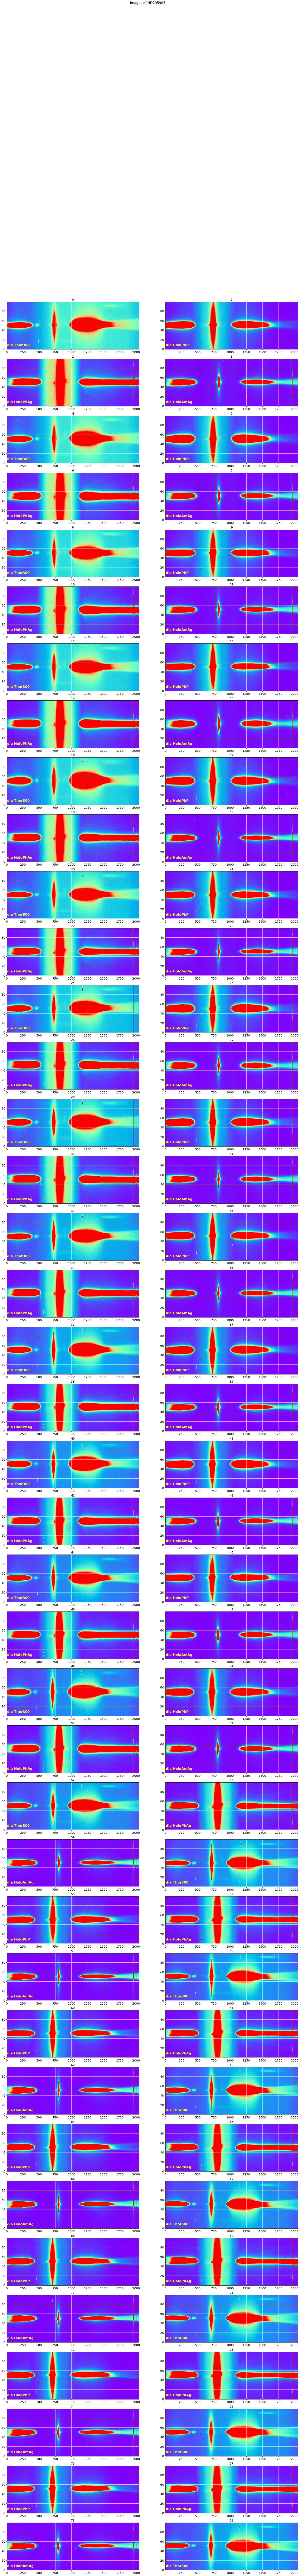

In [ ]:
ShowImages(all_images,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=1000)

## Center of central star

Obviously the previous estimation of the center is wrong

In [1]:
# Center : Order 0
#-------------------
# start at star
y_star0=[all_images[0].shape[0]/2]*len(all_images)
x_star0=x_star2
#ShowCenterImages([1300]*len(all_images),y_star0,[500]*len(all_images),[25]*len(all_images),
#                all_images,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=10000)
ShowCenterImages(x_star0,y_star0,[100]*len(all_images),[50]*len(all_images),
                 all_images,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=10000)

title='Order 0 of spectrum of {} '.format(object_name)
plt.suptitle(title,size=16)
figfilename=os.path.join(dir_top_images,'order0.pdf')
plt.savefig(figfilename)  

NameError: name 'all_images' is not defined

### check weighted_avg_and_std is a good estimator of the central position

In [ ]:
new_x_star,new_y_star=check_central_star(all_images,x_star2,y_star0,all_titles,all_filt)

## Zoom on the rotated image

In [ ]:
# Right spectrum
#---------------
# start at star
#y_star0=[all_images[0].shape[0]/2]*len(all_images)
#x_star0=x_star

y_star0=new_y_star
x_star0=new_x_star
#ShowCenterImages([1300]*len(all_images),y_star0,[500]*len(all_images),[25]*len(all_images),
#                all_images,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=10000)
ShowCenterImages(x_star0+400,y_star0,[600]*len(all_images),[30]*len(all_images),
                 all_images,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=1000,target_pos=np.array([new_x_star,new_y_star]).T)

title='Right part of spectrum of {} '.format(object_name)
plt.suptitle(title,size=16)
figfilename=os.path.join(dir_top_images,'rightorder.pdf')
plt.savefig(figfilename)  

In [ ]:
# Left spectrum
#--------------
#y_star0=[all_images[0].shape[0]/2]*len(all_images)
#x_star0=x_star-600

y_star0=new_y_star
x_star0=new_x_star

#ShowCenterImages([110]*len(all_images),[60]*len(all_images),[500]*len(all_images),[30]*len(all_images),
#                 all_images,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=10000)
ShowCenterImages(x_star0-600,y_star0,[600]*len(all_images),[30]*len(all_images),
                 all_images,all_titles,all_filt,object_name,NBIMGPERROW=2,vmin=0,vmax=1000,target_pos=np.array([new_x_star,new_y_star]).T)
title='Left part of spectrum of {} '.format(object_name)
plt.suptitle(title,size=16)
figfilename=os.path.join(dir_top_images,'leftorder.pdf')
plt.savefig(figfilename)  


# Main emission/absorption lines in nm


In [ ]:
for line in LINES:
    print line['label'],' \t lambda =' ,line['lambda']

# Plot one contour

In [ ]:
sel=0
ShowOneContour(sel,all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'contour_ron400_1.pdf')

In [ ]:
sel=1
ShowOneContour(sel,all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'contour_thor300_1.pdf')

In [ ]:
sel=2
ShowOneContour(sel,all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'contour_holophp_1.pdf')

In [ ]:
sel=3
ShowOneContour(sel,all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'contour_holophag_1.pdf')

In [ ]:
sel=4
ShowOneContour(sel,all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'contour_holoamag_1.pdf')

In [ ]:
ShowOneOrder_contour(all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'firstorderright_contour.pdf')

## Test which transverse spectrum

In [ ]:
sel=0
w0,fwhm0=ShowManyTransverseSpectrum(sel,all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'transverse_thor300.pdf')

In [ ]:
sel=1
w2,fwhm2=ShowManyTransverseSpectrum(sel,all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'transverse_holophp.pdf')

In [ ]:
sel=2
w3,fwhm3=ShowManyTransverseSpectrum(sel,all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'transverse_holophag.pdf')

In [ ]:
sel=3
w4,fwhm4=ShowManyTransverseSpectrum(sel,all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'transverse_holoamag.pdf')

## Summary on fwhm 

In [ ]:
plt.figure(figsize=(6,6))
NBINS=w0.shape[0]
plt.plot(w0,fwhm0,'-',label='Thor300',lw=3)
#plt.plot(w1,fwhm1,'-',label='Ron400',lw=3)
plt.plot(w2,fwhm2,'-',label='Holophp',lw=3)
plt.plot(w3,fwhm3,'-',label='Holophag',lw=3)
plt.plot(w4,fwhm4,'-',label='Holoamag',lw=3)
plt.grid()
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('fwhm (pixels)')
plt.title('fwhm vs wavelength')
plt.legend(loc=2)
figname='fwhm_vs_lambdas_{}.pdf'.format(NBINS)
figfilename=os.path.join(dir_top_images,figname)  
#plt.ylim(0.,25.)
plt.savefig(figfilename)

## Longitudinal spectrum versus transverse width

In [ ]:
sel=0
ShowLongitudinalSpectraSelection(sel,all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'long_thor300_1.pdf')

In [ ]:
sel=1
ShowLongitudinalSpectraSelection(sel,all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'long_holophp_1.pdf')

In [ ]:
sel=2
ShowLongitudinalSpectraSelection(sel,all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'long_holophag_1.pdf')

In [ ]:
sel=3
ShowLongitudinalSpectraSelection(sel,all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'long_holoamag_1.pdf')

## Quality of O2

In [ ]:
sel=0
ShowOneAbsorptionLine(sel,all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'long_o2absline_thor300.pdf')

In [ ]:
sel=1
ShowOneAbsorptionLine(sel,all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'long_o2absline_holophag.pdf')

In [ ]:
sel=2
ShowOneAbsorptionLine(sel,all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'long_o2absline_holophag.pdf')

In [ ]:
sel=3
ShowOneAbsorptionLine(sel,all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'long_o2absline_holoamag.pdf')

# Equivalent width

In [ ]:
sel=0
ShowOneEquivWidth(sel,all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'long_eqwwidth_thor300_1.pdf')

In [ ]:
sel=1
ShowOneEquivWidth(sel,all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'long_eqwwidth_holophp.pdf')

In [ ]:
sel=2
ShowOneEquivWidth(sel,all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'long_eqwwidth_holophag.pdf')

In [ ]:
sel=3
ShowOneEquivWidth(sel,all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'long_eqwwidth_holoamag.pdf')

# Compute equivalent width and show absorption line

In [ ]:
sel=0
CalculateOneAbsorptionLine(sel,all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'calc_eqwwidth_thor300_1.pdf')

In [ ]:
sel=1
CalculateOneAbsorptionLine(sel,all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'calc_eqwwidth_php_1.pdf')

In [ ]:
sel=2
CalculateOneAbsorptionLine(sel,all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'calc_eqwwidth_phag_1.pdf')

In [ ]:
sel=3
CalculateOneAbsorptionLine(sel,all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'calc_eqwwidth_amag_1.pdf')

# Computation of equivalent width and show equivalent width

In [ ]:
sel=0
CalculateOneEquivWidth(sel,all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'calc_eqwwidth_thor300_1.pdf')

In [ ]:
sel=1
CalculateOneEquivWidth(sel,all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'calc_eqwwidth_holophp_1.pdf')

In [ ]:
sel=2
CalculateOneEquivWidth(sel,all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'calc_eqwwidth_holophag_1.pdf')

In [ ]:
sel=3
CalculateOneEquivWidth(sel,all_images,order0_positions,x_star0,y_star0,all_titles,object_name,all_expo,dir_top_images,all_filt,'calc_eqwwidth_holoamag_1.pdf')